### TP 4 :

###### Group : Alexandre BOISTARD, William ROCHE, Ethan TRENTIN

In [13]:
import numpy
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import powerlaw
import statsmodels
from statsmodels import api
from tqdm import tqdm
import Hawkes as hwk

Question 1 : **Brownian motions with Poisson sampling.** Take your results from Lab 2 Question 2 and add the Hayashi-Yoshida estimator to the plot.

We first take the results from Lab 2 Question 2 that was made to simulate Brownian motions with Poisson sampling. So, let's copy the code and improve it.

In [14]:
def simulate_trade_times(mu, T):
    times = []
    t = 0
    while t < T:
        t += numpy.random.exponential(1/mu)
        if t < T:
            times.append(t)
    return numpy.array(times)

In [15]:
def get_trade_prices(time_grid, prices, trade_times):
    # np.searchsorted returns the index of the first element in prices that is greater than or equal to trade_times
    idx = numpy.searchsorted(time_grid, trade_times, side='right')-1
    return prices[idx]

In [16]:
def synchronize_to_grid(trade_times, trade_prices, sampling_times):
    sync_prices = []
    pos = 0
    for gt in sampling_times:
        # We move the position pos until the trade time is greater than the grid time
        while pos < len(trade_times) and trade_times[pos] <= gt:
            pos += 1
        if pos == 0:
            # If no trade has occured yet, we use the set price to NaN or 0.
            sync_prices.append(numpy.nan)
        else:
            sync_prices.append(trade_prices[pos-1])
    return numpy.array(sync_prices)

In [17]:
def compute_covariance_estimator(prices1, prices2):
    # We compute the quadratic variation of the processes.
    returns1 = numpy.diff(prices1)
    returns2 = numpy.diff(prices2)
    return numpy.nansum(returns1 * returns2)

Now, we are going to create a function to get the Hayashi-Yoshida estimator and later add it to the plot of the simulation.

In [18]:
def hayashi_yoshida_estimator(times1, times2, prices1, prices2):
    if len(times1) < 2 or len(times2) < 2:
        return 0.0
    increments1 = numpy.diff(prices1)
    increments2 = numpy.diff(prices2)
    i,j = 1,1
    hayashi_yoshida = 0.0
    while i < len(increments1) and j < len(increments2):
        start = max(times1[i-1], times2[j-1])
        end = min(times1[i], times2[j])
        if start < end:
            hayashi_yoshida += increments1[i-1] * increments2[j-1]
        if times1[i] < times2[j]:
            i += 1
        else:
            j += 1
    return hayashi_yoshida

In [49]:
def simulation(T, n_paths, tau_values, mu_1, mu_2, sigma_1, sigma_2, rho):
    dt = 0.0005
    time_grid = numpy.arange(0, T+dt, dt)
    sampling_grids = {}
    for tau in tau_values:
        sampling_grids[tau] = numpy.arange(0, T + tau, tau)
    # We precompute the Brownian increments on the time grid
    n_steps = len(time_grid)

    Z_1 = numpy.random.normal(0,1,(n_paths, n_steps))
    Z_2 = numpy.random.normal(0,1,(n_paths, n_steps))

    # We compute the correlated increments with the Cholesky factorization
    dW_1 = numpy.sqrt(dt) * Z_1
    dW_2 = numpy.sqrt(dt) * (rho * Z_1 + numpy.sqrt(1-rho**2) * Z_2)

    W_1 = numpy.cumsum(dW_1, axis=1)
    W_2 = numpy.cumsum(dW_2, axis=1)

    p_1_full = sigma_1 * W_1
    p_2_full = sigma_2 * W_2
    cov_estimates = {tau: [] for tau in tau_values}
    Hayashi_Yoshida_estimates = []
    for i in tqdm(range(n_paths)):

        trade_times_1 = simulate_trade_times(mu_1, T)
        trade_times_2 = simulate_trade_times(mu_2, T)

        trade_prices_1 = get_trade_prices(time_grid, p_1_full[i,:], trade_times_1)
        trade_prices_2 = get_trade_prices(time_grid, p_2_full[i,:], trade_times_2)

        for tau in tau_values:

            sampling_times = sampling_grids[tau]

            sync_prices_1 = synchronize_to_grid(trade_times_1, trade_prices_1, sampling_times)
            sync_prices_2 = synchronize_to_grid(trade_times_2, trade_prices_2, sampling_times)
    
            cov_est = compute_covariance_estimator(sync_prices_1, sync_prices_2)
            cov_estimates[tau].append(cov_est)

        Hayashi_Yoshida_estimates.append(hayashi_yoshida_estimator(trade_times_1, trade_times_2, trade_prices_1, trade_prices_2))
        
    theoretical_cov = rho * sigma_1 * sigma_2 * T
    mean_cov = []
    std_cov = []
    for tau in tau_values:
        mean_cov.append(numpy.nanmean(cov_estimates[tau]))
        std_cov.append(numpy.nanstd(cov_estimates[tau]))

    mean_cov = numpy.array(mean_cov)
    std_cov = numpy.array(std_cov)

    mean_HY = numpy.mean(Hayashi_Yoshida_estimates)
    std_HY = numpy.std(Hayashi_Yoshida_estimates)
    plt.figure(figsize=(8, 6))
    plt.plot(tau_values, mean_cov, label='Mean covariance estimate', marker='o')
    plt.fill_between(tau_values, mean_cov - 2*std_cov, mean_cov + 2*std_cov, alpha=0.3, label='Theoretical ±2 std (grid-based)')
    plt.axhline(theoretical_cov, color='black', linestyle='dashed', linewidth=2, label='Theoretical covariance')
    plt.axhline(mean_HY, color='red', linestyle='-', linewidth=2, label='Mean Hayashi-Yoshida estimate')
    plt.fill_between(tau_values, mean_HY - 2*std_HY, mean_HY + 2*std_HY, alpha=0.3, label='Hayashi-Yoshida ±2 std')
    plt.xscale('log') 
    plt.xlabel("Sampling period ($\tau$)")
    plt.ylabel("Covariance estimate")
    plt.title(f"Mean covariance estimates over {n_paths} paths vs. sampling period ($\tau$)")
    plt.legend()
    plt.show()

In [47]:
# Let's define the parameters of the model
T = 1 # Total time
n_paths = 2000 # Number of paths                                            
mu_1 = 100 # Intensity of the first Poisson process
mu_2= 120 # Intensity of the second Poisson process
sigma_1 = 1.0
sigma_2 = 1.5
rho = 0.5 # Correlation between the 2 Brownian motions
tau_values = numpy.logspace(-3, 0, 20) # Sampling periods

100%|██████████| 2000/2000 [01:08<00:00, 29.38it/s]


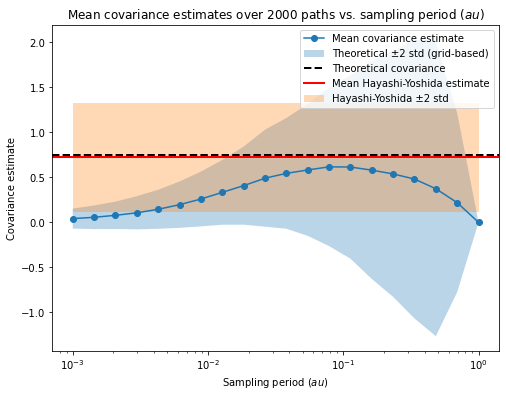

In [50]:
simulation(T, n_paths, tau_values, mu_1, mu_2, sigma_1, sigma_2, rho)